# Sparse Spiking Ensemble - Temporal coding

- Ensemble = Sensory neurons + latent neurons
- Sensory neurons get spikes from sensory inputs
- Sensory inputs are sparse coded (~20% 1s, rest 0s)
- Each neuron also takes input from the whole ensemble (later to be restricted locally)

## New in this notebook
- Use afferent weights to inhibit input when a neuron fires. Over time we expect to see cyclical neural activation. Pattern is shown --> some neurons become active --> they inhibit parts of the pattern that they represent --> (residual pattern activates other set of neurons --> they inhibit the input)* --> original pattern is no longer inhibited and that leads to the cycle to repeat.
- First we need to set up an input neuron layer that connect 1-1 to sensory inputs. Or maybe it can simply be represented as a trace that receives sensory input as well as feedback inhibition, and the trace is what goes to the sensory neurons.
- Initiallg we will work with non-noisy patterns. This should result in a clear (ramp up, ramp down)* pattern of neural activity for neurons that recognise that pattern. This is because after recognition, the whole pattern will start to fade out.

## Results


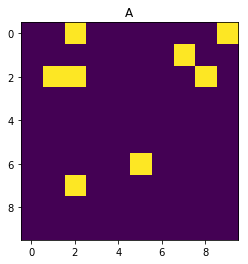

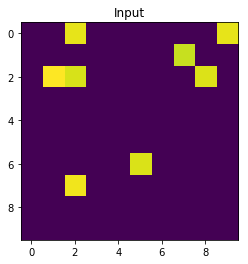

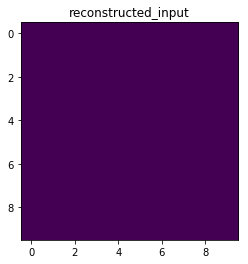

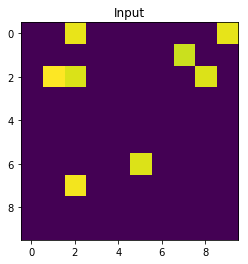

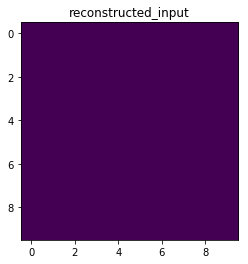

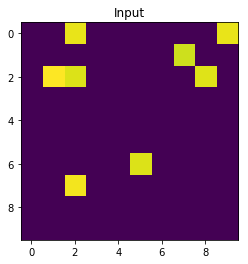

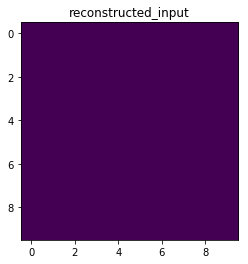

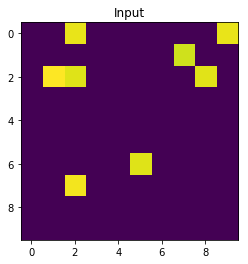

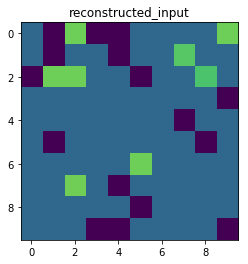

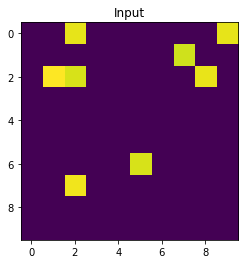

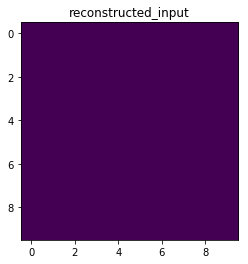

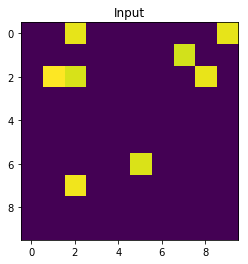

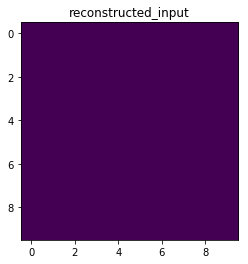

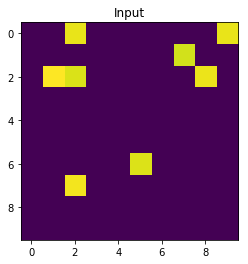

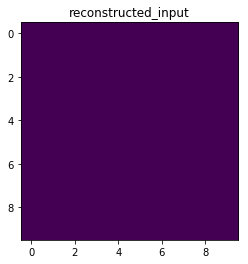

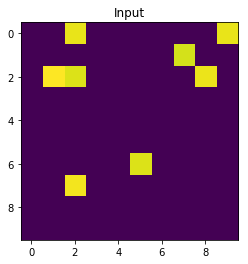

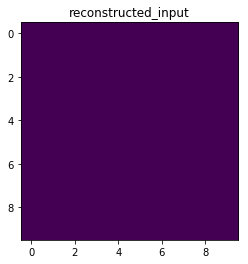

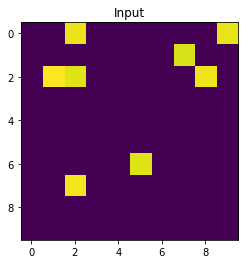

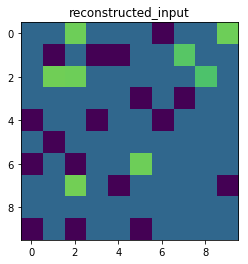

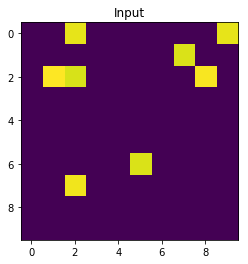

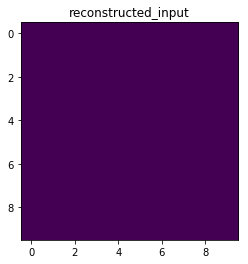

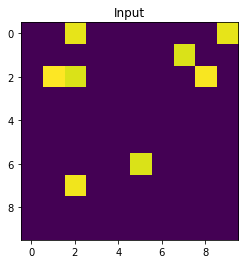

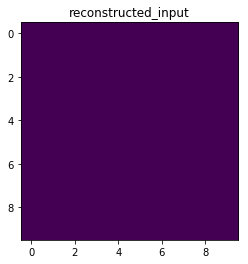

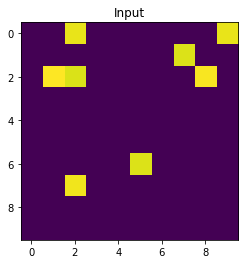

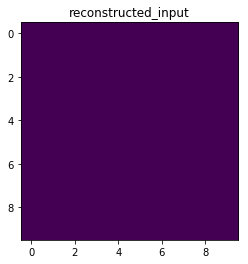

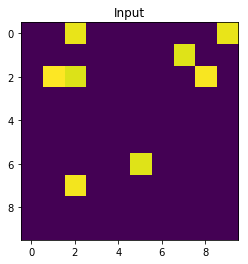

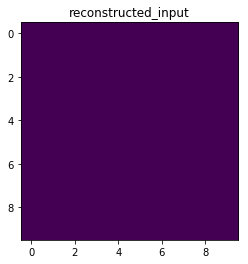

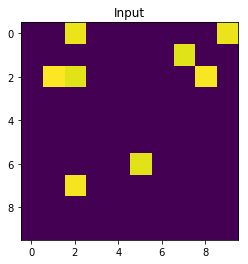

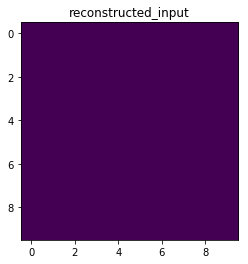

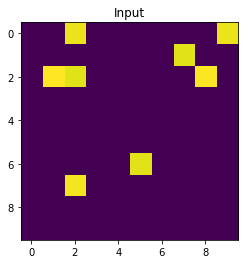

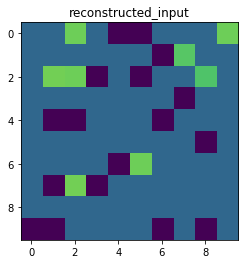

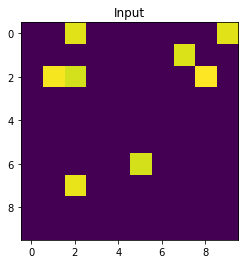

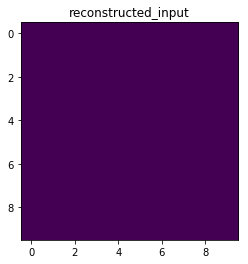

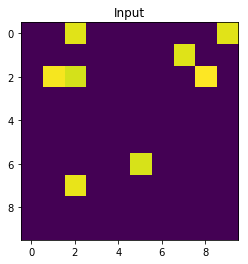

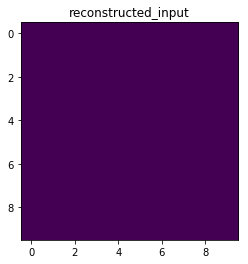

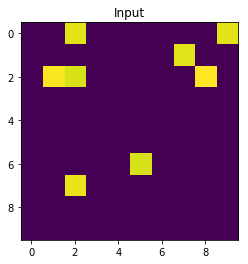

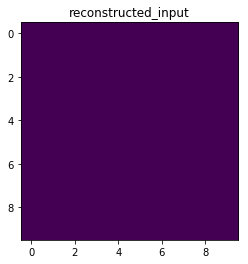

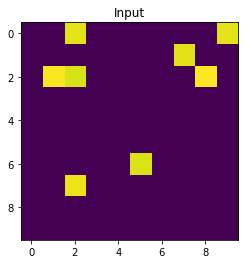

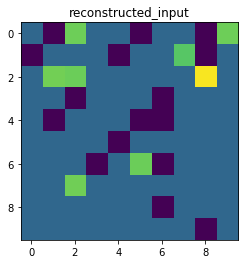

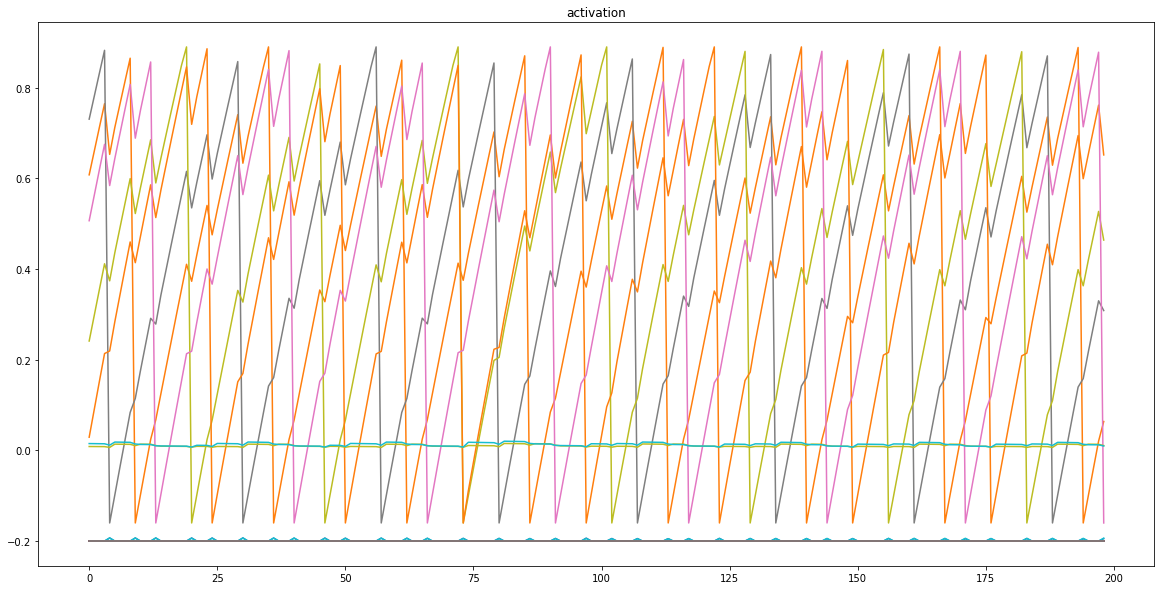

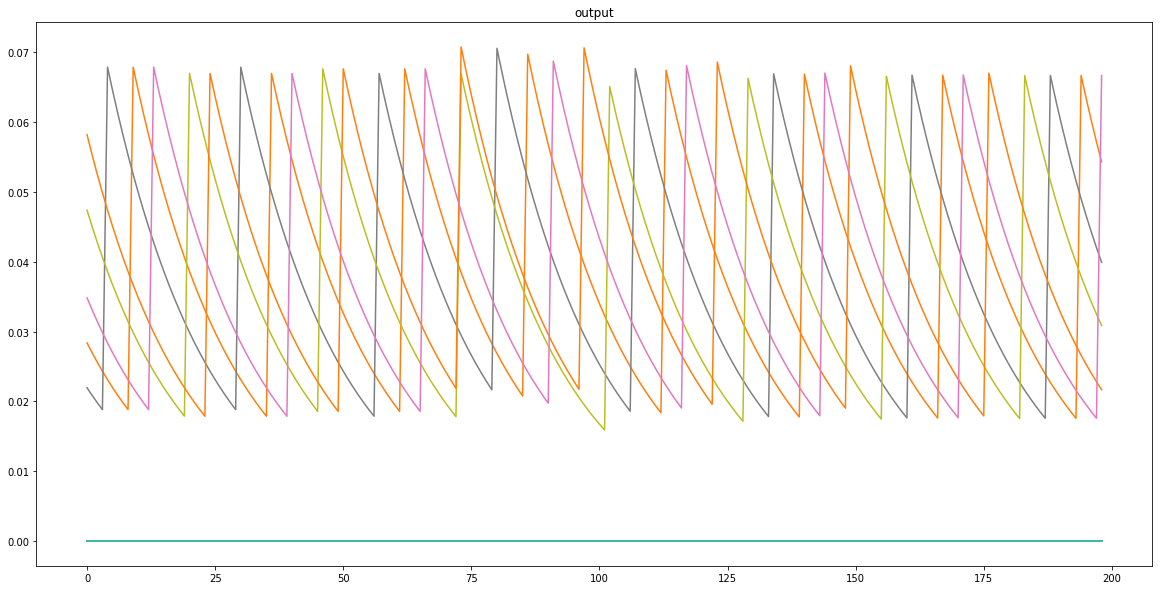

In [84]:
from collections import defaultdict
import torch
import matplotlib.pyplot as plt

SENSORY_MODALITY_1_WIDTH = 10
SENSORY_MODALITY_1_HEIGHT = 10
SENSORY_MODALITY_1_SIZE = SENSORY_MODALITY_1_WIDTH * SENSORY_MODALITY_1_HEIGHT

SENSORY_MODALITY_1_NEURONS = 18
LATENT_NEURONS = 2

SPARSITY = 0.1
NEGATIVE_WEIGHT = 0.2

ENSEMBLE_NEURONS = SENSORY_MODALITY_1_NEURONS + LATENT_NEURONS
ENSEMBLE_WIDTH = 5
ENSEMBLE_HEIGHT = 4
assert(ENSEMBLE_WIDTH * ENSEMBLE_HEIGHT == ENSEMBLE_NEURONS)

def make_sparse_embedding(size):
  return (torch.FloatTensor(size).uniform_() < SPARSITY).long().float()

MODALITY_1_SYMBOLS = {
    '0': make_sparse_embedding(SENSORY_MODALITY_1_SIZE) * 0.0,
    'A': make_sparse_embedding(SENSORY_MODALITY_1_SIZE),
    'B': make_sparse_embedding(SENSORY_MODALITY_1_SIZE),
    'C': make_sparse_embedding(SENSORY_MODALITY_1_SIZE),
    'D': make_sparse_embedding(SENSORY_MODALITY_1_SIZE),
    'E': make_sparse_embedding(SENSORY_MODALITY_1_SIZE),
}

V_THRESHOLD = 0.9
V_ZERO = 0
V_RESET = -0.2

def show_input(input, title):
  plt.title(title)
  plt.imshow(input.view((SENSORY_MODALITY_1_HEIGHT, SENSORY_MODALITY_1_WIDTH)).numpy(), vmin=0, vmax=1)
  plt.show()

class Trace:
  def __init__(self, shape, alpha=0.05):
    self.trace = torch.zeros(shape)
    self.alpha = alpha

  def add(self, values):
    self.trace = self.trace * (1 - self.alpha) + values * self.alpha
    return self.trace

class Network:
  def __init__(self):
    self.activation = torch.zeros(ENSEMBLE_NEURONS)
    self.output = torch.zeros(ENSEMBLE_NEURONS)
    self.output_trace = Trace((ENSEMBLE_NEURONS,))

    self.afferent_weights = torch.zeros((SENSORY_MODALITY_1_NEURONS, SENSORY_MODALITY_1_SIZE)).uniform_() - NEGATIVE_WEIGHT  # weights [-NEGATIVE_WEIGHT, 1-NEGATIVE_WEIGHT], e.g. [-0.2, 0.8]
    #self.afferent_weights = torch.ones((SENSORY_MODALITY_1_NEURONS, SENSORY_MODALITY_1_SIZE)) - NEGATIVE_WEIGHT  # weights [-NEGATIVE_WEIGHT, 1-NEGATIVE_WEIGHT], e.g. [-0.2, 0.8]
    #self.afferent_weights[0] -= 0.1
    # print("self.afferent_weights", self.afferent_weights)
    
    self.lateral_weights  = torch.zeros((ENSEMBLE_NEURONS, ENSEMBLE_NEURONS)).uniform_() - NEGATIVE_WEIGHT

    self.lateral_weights[torch.eye(ENSEMBLE_NEURONS).byte()] = 0

    self.afferent_trace = Trace((SENSORY_MODALITY_1_SIZE,))
    self.lateral_trace = Trace((ENSEMBLE_NEURONS,))
    self.learning_rate = 0.1
    self.lateral_inhibition = 1 / ENSEMBLE_NEURONS
    self.activation_alpha = 1.0 / SENSORY_MODALITY_1_SIZE
    self.activiation_decay = 0.0001
    
    self.captured_attributes = ['activation']
    self.figsize = (20, 10)
    self.reset_history()

  def reset_history(self):
    self.history = defaultdict(lambda: [])

  def capture_history(self):
    for attr_name in self.captured_attributes:
      self.history[attr_name].append(getattr(self, attr_name).clone())

    self.history['output'].append(self.output_trace.trace.clone())

  def report(self):
    for attr_name in self.history.keys():
      data = torch.stack(self.history[attr_name]).numpy()
      plt.figure(figsize=self.figsize)
      plt.plot(data)
      plt.title(attr_name)
      plt.show()

  def plot_activation(self):
    plt.imshow(self.activation.view((ENSEMBLE_HEIGHT, ENSEMBLE_WIDTH)).numpy())
    plt.show()

  def plot_output_trace(self):
    plt.imshow(self.output_trace.trace.view((ENSEMBLE_HEIGHT, ENSEMBLE_WIDTH)).numpy())
    plt.show()

  def present_input(self, sensory_input):
    # Decay activation
    self.activation *= (1.0 - self.activiation_decay)
    # print("self.activation after decay", self.activation)

    # Sensory inputs and trace
    weighted_input = self.afferent_weights * sensory_input
    self.afferent_trace.add(sensory_input)   # NOTE: Trace of inputs before applying weights
    weighted_input = weighted_input.sum(dim=1)
    # print("weighted_input", weighted_input)
    # print("self.afferent_trace", self.afferent_trace)

    # Lateral inputs (i.e. previous output) and trace
    weighted_lateral_input = self.lateral_weights * self.output
    self.lateral_trace.add(self.output)      # NOTE: Trace of lateral inputs before applying weights
    weighted_lateral_input = weighted_lateral_input.sum(dim=1)
    # print("weighted_lateral_input", weighted_lateral_input)
    # print("self.lateral_trace", self.lateral_trace)

    # Total input
    total_input = weighted_lateral_input
    total_input[0:SENSORY_MODALITY_1_NEURONS] += weighted_input
    # print("total_input", total_input)

    # Add input to activation
    self.activation = self.activation * (1 - self.activation_alpha) + total_input * self.activation_alpha
    # print("self.activation 1", self.activation)

    # Fire!
    active = (self.activation > V_THRESHOLD)
    self.activation[active] = V_RESET
    # print("Firing", active)

    # Currently active
    self.output = active.float()
    self.output_trace.add(self.output)

    # print("self.afferent_weights", self.afferent_weights)
    # Learning
    fired_indices = active.nonzero()
    if fired_indices.nelement() > 0:
      # print("self.afferent_trace", self.afferent_trace)
      for i in fired_indices:
        fired_index = i.item()

        # print("=========================")
        # print("Fired", fired_index)

        # afferent connections
        dist_from_trace = self.afferent_trace.trace - self.afferent_weights
        # print("dist_from_trace[fired_index]", dist_from_trace[fired_index])
        dw_afferent_self = self.learning_rate * dist_from_trace[fired_index]
        # print("dw_afferent_self", dw_afferent_self)
        # print("self.afferent_weights[fired_index] before", self.afferent_weights[fired_index])
        self_afferent_weights = self.afferent_weights[fired_index].clone()
        self_afferent_weights += dw_afferent_self
        # print("self.afferent_weights[fired_index] after", self_afferent_weights)

        # Lateral inhibition
        min_dist = 0.01
        dist_from_trace[dist_from_trace.abs() < min_dist] = min_dist * dist_from_trace[dist_from_trace.abs() < min_dist].sign() # prep for division
        dw_afferent_neighbor = - self.learning_rate * self.lateral_inhibition * (1 / dist_from_trace) * (1 - self.afferent_weights.abs())
        # print("dw_afferent_neighbor", dw_afferent_neighbor)
        self.afferent_weights += dw_afferent_neighbor

        # Actually set self afferent weights here to prevent self-inhibition
        self.afferent_weights[fired_index] = self_afferent_weights

      # print("self.afferent_weights", self.afferent_weights)
      self.activation *= 0.8

    reconstructed_input = self.afferent_weights[active[0:SENSORY_MODALITY_1_NEURONS]].clone()
    reconstructed_input[reconstructed_input < 0] = 0
    reconstructed_input = reconstructed_input.sum(dim=0)
    reconstructed_input[reconstructed_input > 1] = 1
    #if fired_indices.nelement() > 0:
    #  show_input(reconstructed_input, 'Reconstructed Input')

    # Keep activation within bounds
    torch.clamp(self.activation, V_RESET, V_THRESHOLD - 0.01, out=self.activation)
    # self.activation[self.activation < V_RESET] = V_RESET
    # self.activation[self.activation > V_MAX] = V_MAX
    # print("self.activation clamped", self.activation)
    self.capture_history()

    return reconstructed_input


# print(MODALITY_1_SYMBOLS['A'])
network = Network()
sensory_input_trace = Trace(MODALITY_1_SYMBOLS[symbol].shape)

show_input(MODALITY_1_SYMBOLS['A'], 'A')

for i in range(3000):
  sensory_input_trace.add(MODALITY_1_SYMBOLS['A'])
  reconstructed_input = network.present_input(sensory_input_trace.trace)
  if i == 2800:
    network.reset_history()
    
  if i > 2980:
    show_input(sensory_input_trace.trace, 'Input')
    show_input(reconstructed_input, 'reconstructed_input')

  sensory_input_trace.trace -= reconstructed_input * 0.3
  sensory_input_trace.trace.clamp_(0.0, 1.0)
  sensory_input_trace.trace /= sensory_input_trace.trace.max()

network.report()



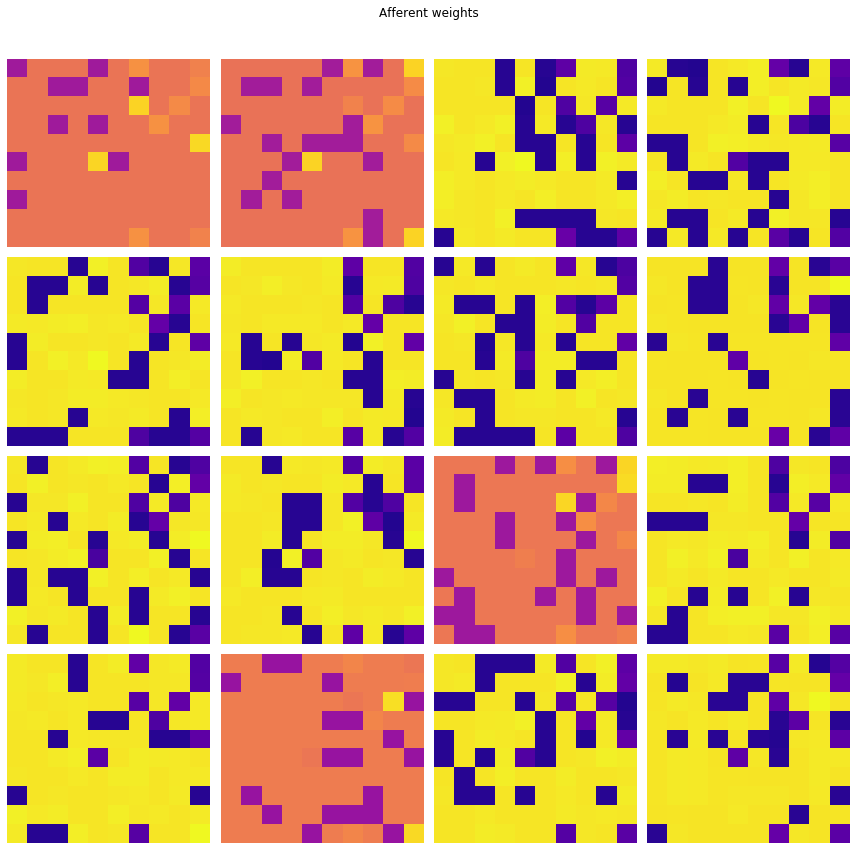

In [80]:
def plot_afferent_weights(weights, image_height=SENSORY_MODALITY_1_HEIGHT, image_width=SENSORY_MODALITY_1_WIDTH, title='Afferent weights'):
  assert(len(weights.shape) == 2)

  resolution = int(weights.shape[0] ** 0.5)

  fig, axs = plt.subplots(nrows=resolution, ncols=resolution, figsize=(resolution*3, resolution*3),
                        subplot_kw={'xticks': [], 'yticks': []})

  axs = axs.flat
  for i in range(resolution * resolution):
    axs[i].axis("off")
    axs[i].imshow(weights[i].view((image_height, image_width)).numpy(), vmin=-1, vmax=1, interpolation='none', cmap=plt.cm.plasma, aspect='auto')

  plt.suptitle(title)
  plt.tight_layout()
  fig.subplots_adjust(top=0.92)
  plt.show()

plot_afferent_weights(network.afferent_weights)

In [75]:
network.afferent_weights[6]

tensor([-0.2995,  0.2995,  0.2995,  0.2995, -0.2995,  0.2995,  0.8650,  0.2995,
         0.2995,  0.2995, -0.2995,  0.2995,  0.2995,  0.2995,  0.2995,  0.2995,
         0.2995,  0.2995,  0.2995,  0.2995,  0.2995,  0.2995,  0.2995,  0.2995,
         0.2995,  0.2995,  0.2995,  0.2995,  1.0000,  0.8650,  0.2995,  0.2995,
         0.2995,  0.2995,  0.2995,  0.2995,  0.2995,  0.2995,  0.2995,  0.2995,
         0.2995,  0.2995,  0.2995,  0.2995,  0.2995,  0.2995,  0.8650,  0.2995,
         0.2995,  0.2995,  0.2995,  0.2995,  0.8650,  0.2995,  0.2995,  0.2995,
         0.2995,  0.2995,  0.2995,  0.2995,  0.2995,  0.2995,  0.2995,  0.2995,
         0.2995,  0.2995,  0.2995,  0.2995,  0.2995,  0.2995, -0.2995,  0.2995,
         0.8650,  0.2995,  0.2995,  0.2995,  0.2995,  0.2995,  0.2995, -0.2995,
         0.2995,  0.2995,  0.2995,  0.2995,  0.2995, -0.2995, -0.2995,  0.2995,
         0.8650,  0.2995,  0.2995,  0.2995,  0.2995,  0.2995,  0.2995, -0.2995,
        -0.2995,  0.2995,  0.2995,  0.29